https://www.kaggle.com/code/carolineecc/xg-boost-random-forest-ridge-lasso-regression

# 1. Importing Neccessary Libraries

In [34]:
import pandas as pd
import pickle
import numpy as np
import re
from sklearn import linear_model


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

import os
import warnings
warnings.filterwarnings('ignore') 
from pandas_profiling import ProfileReport

# 2. Understanding the Data Set

In [35]:
train = pd.read_csv('data/train.csv', parse_dates = ['datetime'])
test = pd.read_csv('data/test.csv', parse_dates = ['datetime'])

In [36]:
print(train.shape)
print(train.head())
print(train.dtypes)

(10886, 12)
             datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1  
datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity  

In [4]:
profile = ProfileReport(train, title="Pandas Profiling Report")
profile

In [5]:
# Export html report
profile.to_file("train_profiling_report.html")

In [37]:
print(test.shape)
print(test.columns)
print([i for i in train.columns if i not in test.columns]) 

(6493, 9)
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')
['casual', 'registered', 'count']


In [38]:
train = train.drop(['casual','registered'],axis=1)
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  count  
0        81        0.0     16  
1        80        0.0     40  
2        80        0.0     32  
3        75        0.0     13  
4        75        0.0      1

In [39]:
def rmsle(y_log, y0_log):
    return np.sqrt(np.mean(np.square(y_log - y0_log)))

# 3. EDA & Feature Engineering

In [40]:
# Remove Outliers
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 

In [41]:
for df in (train,test):
    
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hr'] = df['datetime'].dt.hour

    df['hr_categori'] = np.nan
    df.loc[(df.workingday == 1)&(df.hr <= 9)&(df.hr >= 7), 'hr_categori'] = "rush"
    df.loc[(df.workingday == 1)&(df.hr <= 19)&(df.hr >= 16), 'hr_categori'] = "rush"
    df.loc[(df.workingday == 1)&(df.hr < 16)&(df.hr > 9), 'hr_categori'] = "day"
    df.loc[(df.workingday == 1)&(df.hr < 7)|(df.hr > 19), 'hr_categori'] = "night"

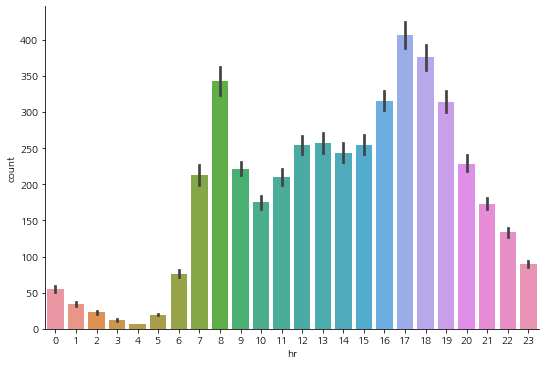

In [42]:
# HOUR
sns.factorplot(x="hr",y="count",data=train,kind='bar',size=5,aspect=1.5)

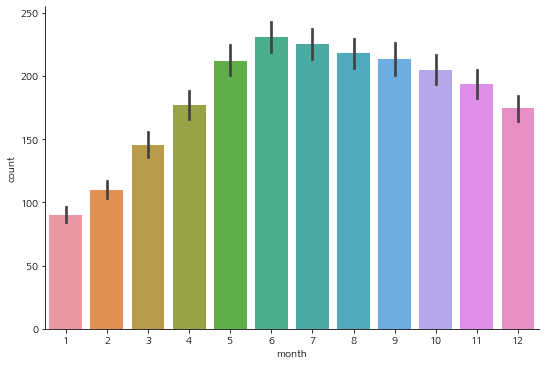

In [43]:
# Month
sns.factorplot(x="month",y="count",data=train,kind='bar',size=5,aspect=1.5)

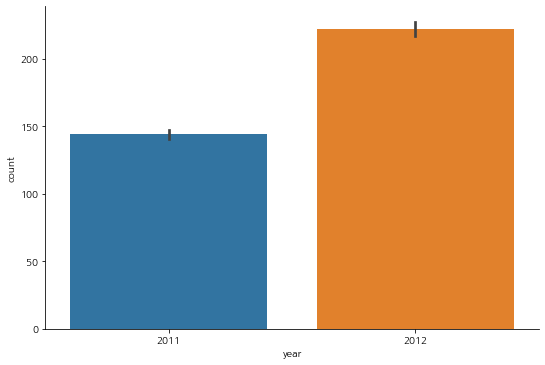

In [44]:
# Year
sns.factorplot(x="year",y="count",data=train,kind='bar',size=5,aspect=1.5)

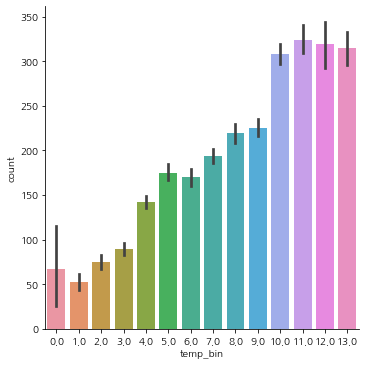

In [45]:
# Temp
new_df=train.copy()

new_df['temp_bin']=np.floor(new_df['temp'])//3

sns.factorplot(x="temp_bin",y="count",data=new_df,kind='bar')

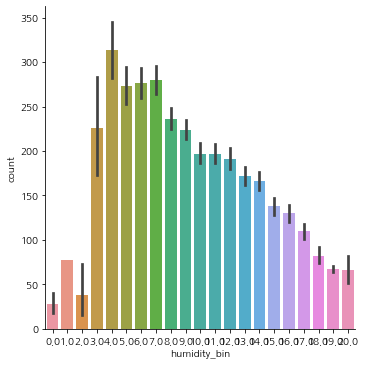

In [46]:
# Humidity
new_df=train.copy()
new_df['humidity_bin']=np.floor(new_df['humidity'])//5

sns.factorplot(x="humidity_bin",y="count",data=new_df,kind='bar')

In [47]:
for df in (train,test):
    df['humi_categori'] = np.nan
    df.loc[df.humidity < 15, 'humi_categori'] = 'low'
    df.loc[(df.humidity <= 85)&(df.humidity >= 15), 'humi_categori'] = 'normal'
    df.loc[(df.humidity >= 85), 'humi_categori'] = 'high'

In [48]:
# Windspeed
train[train['windspeed']>=48]

datetime  season  holiday  workingday  weather   temp  atemp  \
760  2011-02-15 01:00:00       1        0           1        1  12.30  12.12   
868  2011-02-19 15:00:00       1        0           0        1  18.04  21.97   
2755 2011-07-03 17:00:00       3        0           0        3  32.80  37.12   
2756 2011-07-03 18:00:00       3        0           0        3  32.80  37.12   

      humidity  windspeed  count  year  month  day  hr hr_categori  \
760         42    51.9987      5  2011      2   15   1       night   
868         16    50.0021    171  2011      2   19  15         NaN   
2755        49    56.9969    358  2011      7    3  17         NaN   
2756        49    56.9969    181  2011      7    3  18         NaN   

     humi_categori  
760         normal  
868         normal  
2755        normal  
2756        normal

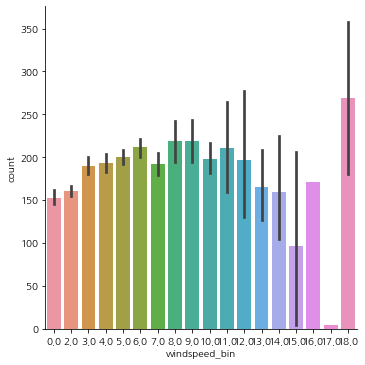

In [49]:
new_df=train.copy()

new_df['windspeed_bin']=np.floor(new_df['windspeed'])//3
sns.factorplot(x="windspeed_bin",y="count",data=new_df,kind='bar')

In [50]:
for df in (train,test):
    df['wind_categori'] = np.nan
    df.loc[df.windspeed < 15, 'wind_categori'] = 'normal'
    df.loc[(df.windspeed >= 15), 'wind_categori'] = 'high'

## 3.1 Convert categorical variable into dummy variables

In [51]:
weather_train = pd.get_dummies(train['weather'], prefix='wea', prefix_sep='_')
weather_test = pd.get_dummies(test['weather'], prefix='wea', prefix_sep='_')

season_train = pd.get_dummies(train['season'], prefix='sea', prefix_sep='_')
season_test = pd.get_dummies(test['season'], prefix='sea', prefix_sep='_')

year_train = pd.get_dummies(train['year'], prefix='year', prefix_sep='_')
year_test = pd.get_dummies(test['year'], prefix='year', prefix_sep='_')

wind_categori_train = pd.get_dummies(train['wind_categori'], prefix='wind_cate', prefix_sep='_')
wind_categori_test = pd.get_dummies(test['wind_categori'], prefix='wind_cate', prefix_sep='_')

humi_categori_train = pd.get_dummies(train['humi_categori'], prefix='humi_cate', prefix_sep='_')
humi_categori_test = pd.get_dummies(test['humi_categori'], prefix='humi_cate', prefix_sep='_')

hr_categori_train = pd.get_dummies(train['hr_categori'], prefix='hr_cate', prefix_sep='_')
hr_categori_test = pd.get_dummies(test['hr_categori'], prefix='hr_cate', prefix_sep='_')

## 3.2 Train/Test Set Integration

In [52]:
Train_Master = pd.concat([train,
                         weather_train,
                         season_train,
                         year_train,
                         wind_categori_train,
                         humi_categori_train,
                         hr_categori_train], axis=1)

Test_Master = pd.concat([test,
                          weather_test,
                          season_test,
                          year_test,
                          wind_categori_test,
                          humi_categori_test,
                          hr_categori_test], axis=1)

In [53]:
Train_Master = Train_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)
Test_Master = Test_Master.drop(['weather','season','year','datetime','hr_categori','humi_categori','wind_categori'], axis = 1)

Train, Test = train_test_split(Train_Master, test_size=0.3)

In [54]:
X_train = Train.drop(['count'], axis=1)
Y_train = Train['count']
Y_train_log = Train['count'].apply(lambda x:np.log1p(x))

X_test = Test.drop(['count'], axis=1)
Y_test = Test["count"]
Y_test_log = Test["count"].apply(lambda x:np.log1p(x))

Y_test = Y_test.reset_index().drop('index', axis=1)
Y_train = Y_train.reset_index().drop('index', axis=1)

In [55]:
print(Train_Master.columns, Train_Master.shape)
print(Test_Master.columns, Test_Master.shape)
print([i for i in Train_Master.columns if i not in Test_Master.columns])

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'count', 'month', 'day', 'hr', 'wea_1', 'wea_2', 'wea_3', 'wea_4',
       'sea_1', 'sea_2', 'sea_3', 'sea_4', 'year_2011', 'year_2012',
       'wind_cate_high', 'wind_cate_normal', 'humi_cate_high', 'humi_cate_low',
       'humi_cate_normal', 'hr_cate_day', 'hr_cate_night', 'hr_cate_rush'],
      dtype='object') (10739, 28)
Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'month', 'day', 'hr', 'wea_1', 'wea_2', 'wea_3', 'wea_4', 'sea_1',
       'sea_2', 'sea_3', 'sea_4', 'year_2011', 'year_2012', 'wind_cate_high',
       'wind_cate_normal', 'humi_cate_high', 'humi_cate_normal', 'hr_cate_day',
       'hr_cate_night', 'hr_cate_rush'],
      dtype='object') (6493, 26)
['count', 'humi_cate_low']


# 4. Auto Tuning

In [56]:
def lasso_autotune(X, y):
    
    param_test = {
     'max_iter':[5000],
     'alpha':[1e-10, 1e-8, 1e-4,1e-2, 1, 5, 10, 100, 500, 1000]
    }
    
    gsearch = GridSearchCV(Lasso(fit_intercept=True, normalize=True, selection='random'), refit=True,
                          param_grid=param_test, scoring='neg_mean_squared_error', iid=True, cv=5)
    
    gsearch.fit(X, y)
    print('____________________________________________')
    print('tune lasso')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X), y))
    
    return gsearch.best_estimator_

In [57]:
def ridge_autotune(X,y):

    param_test = {
     'max_iter':[5000],        
     'alpha':[1e-10, 1e-8, 1e-4,1e-2, 1, 5, 10, 100],
     'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
    }

    gsearch = GridSearchCV(Ridge(),refit=True,
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune ridge')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [58]:
def random_forest_autotune(X,y):

    param_test = {
     'max_depth':[9,13,17],
     'max_features':['auto','sqrt'],
     'n_estimators': [500,1000,1500]
    }

    gsearch = GridSearchCV(RandomForestRegressor(),refit=True,
                            param_grid = param_test, scoring='neg_mean_squared_error',iid=True, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune random forest')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))

    return gsearch.best_estimator_

In [59]:
def xgb_autotune(X,y):
    param = {
            'objective':'reg:squarederror',
            'n_estimators':1000,
            'learning_rate':0.05,
            'gamma':0,
            'max_depth':5,
            'min_child_weight':1,
            'colsample_bytree':0.5,
            'subsample': 0.8, 
            'verbose':1,
            'reg_alpha':0}


    param_test1 = {
     'max_depth':[7,13,15],
     'reg_alpha':[0.1,1,10,100],
     'learning_rate':[0.05,0.1],
    }

    gsearch = GridSearchCV(xgb.XGBRegressor(objective=param['objective'],
                              n_estimators=param['n_estimators'], learning_rate = param['learning_rate'], gamma=param['gamma'],
                              colsample_bytree=param['colsample_bytree'], subsample=param['subsample'], reg_alpha=param['reg_alpha']
                              ),
                            param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5)
    gsearch.fit(X,y)
    print('____________________________________________')
    print('tune max_depth, min_child_weight')
    print('____________________________________________')
    print(gsearch.cv_results_)
    print(gsearch.best_params_)
    print(gsearch.best_score_)
    print(rmsle(gsearch.predict(X),y))
    return gsearch.best_estimator_

# 5. Fitting 1st layer models

In [60]:
lasso_param = lasso_autotune(X_train,Y_train_log)
ridge_param = ridge_autotune(X_train,Y_train_log)
xgb_param = xgb_autotune(X_train,Y_train_log)
random_forest_param = random_forest_autotune(X_train,Y_train_log)

____________________________________________
tune lasso
____________________________________________
{'mean_fit_time': array([0.92185006, 0.98559322, 0.03427458, 0.00647125, 0.00658984,
       0.00673747, 0.00757203, 0.00695372, 0.00729084, 0.00738482]), 'std_fit_time': array([0.18458372, 0.25299341, 0.00498943, 0.00048484, 0.00052446,
       0.00064902, 0.00134339, 0.00066489, 0.00036848, 0.00141616]), 'mean_score_time': array([0.00362554, 0.002599  , 0.00222235, 0.00228271, 0.00190315,
       0.00201464, 0.00239635, 0.00213599, 0.00247412, 0.00239449]), 'std_score_time': array([2.77440749e-03, 4.85892174e-04, 4.29422543e-04, 3.84694317e-04,
       1.81960247e-04, 2.29080432e-05, 2.83911303e-04, 4.40666551e-04,
       5.81718710e-04, 3.93262189e-04]), 'param_alpha': masked_array(data=[1e-10, 1e-08, 0.0001, 0.01, 1, 5, 10, 100, 500, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtyp

____________________________________________
tune max_depth, min_child_weight
____________________________________________
{'mean_fit_time': array([ 5.40501981,  5.531075  ,  7.67680531,  2.24346123, 14.57647276,
       10.89824548,  5.52933421,  1.92452974, 14.34319162, 10.17902179,
        6.10482326,  2.44623556,  6.45233164,  6.5492588 ,  5.13962674,
        2.11884241, 11.53064179, 12.5294836 ,  6.38530679,  2.00559759,
       12.59271321, 12.7179719 , 11.16995063,  3.12764492]), 'std_fit_time': array([0.04032304, 0.12175801, 2.40968605, 0.32067161, 1.81434124,
       2.5179479 , 0.1913382 , 0.03502028, 2.60433134, 0.43228108,
       0.50382907, 0.19943745, 0.15039495, 0.25744222, 0.17923136,
       0.42620313, 1.07619752, 2.04014779, 0.1396672 , 0.29808453,
       1.32070515, 4.204132  , 2.83172315, 0.42746461]), 'mean_score_time': array([0.13295999, 0.12946024, 0.23165693, 0.02137003, 0.96587076,
       0.29217992, 0.10051537, 0.01779222, 0.75135279, 0.27235565,
       0.1159906

0.12759519988718904


In [64]:
model_names=['lasso','ridge','xgb','random forest']
rmsles=[]

print('='*15)
print('lasso test score')
rmsles.append(rmsle(lasso_param.predict(X_test), Y_test_log))
print(rmsle(lasso_param.predict(X_test), Y_test_log))
print('='*15)

print('='*15)
print('ridge test score')
rmsles.append(rmsle(ridge_param.predict(X_test), Y_test_log))
print(rmsle(ridge_param.predict(X_test), Y_test_log))
print('='*15)

print('='*15)
print('xgb test score')
rmsles.append(rmsle(xgb_param.predict(X_test),Y_test_log))
print(rmsle(xgb_param.predict(X_test),Y_test_log))
print('='*15)

print('='*15)
print('random forest test score')
rmsles.append(rmsle(random_forest_param.predict(X_test),Y_test_log))
print(rmsle(random_forest_param.predict(X_test),Y_test_log))
print('='*15)

d={'Modelling Algo':model_names,'RMSLE':rmsle} 
print(d)

lasso test score
0.7552807552081018
ridge test score
0.7552024528198346
xgb test score
0.30698427766700503
random forest test score
0.33345086541260344
{'Modelling Algo': ['lasso', 'ridge', 'xgb', 'random forest'], 'RMSLE': <function rmsle at 0x000001C34DBDB798>}


# 6. Fitting 2nd layer model

In [65]:
predict_met = pd.DataFrame(data={method: [np.nan] * X_train.shape[0] for method in ['lasso', 'ridge', 'xgb', 'random forest']})

In [66]:
predict_met['lasso'] = lasso_param.predict(X_train)
predict_met['ridge'] = ridge_param.predict(X_train)
predict_met['xgb'] = xgb_param.predict(X_train)
predict_met['random forest'] = random_forest_param.predict(X_train)

predict_met.head()

lasso     ridge       xgb  random forest
0  4.831740  4.831275  5.679316       5.620791
1  5.051862  5.051401  5.603641       5.701534
2  5.912527  5.912111  5.757179       5.734245
3  5.777568  5.777246  5.968513       5.896611
4  5.185049  5.184540  5.214616       5.263751

In [67]:
ensemble_xgb = xgb_autotune(predict_met, Y_train_log)

____________________________________________
tune max_depth, min_child_weight
____________________________________________
{'mean_fit_time': array([2.3552845 , 2.64750147, 1.2654758 , 0.71342406, 4.8042665 ,
       4.07836771, 1.33213301, 0.8484767 , 6.45866647, 4.13140235,
       1.29382668, 0.75375662, 2.59942374, 2.69959664, 1.07775521,
       0.66452069, 4.82542124, 3.62982221, 1.08967605, 0.66674647,
       6.97899146, 4.41967268, 1.18088908, 0.70366273]), 'std_fit_time': array([0.0565168 , 0.11772383, 0.09461721, 0.04772135, 0.11620053,
       0.32731016, 0.14208774, 0.09357747, 1.50265585, 0.36629577,
       0.09969823, 0.0538471 , 0.02300347, 0.03807077, 0.12614182,
       0.03784536, 0.0964562 , 0.0388995 , 0.09630716, 0.03526014,
       2.3528236 , 0.5956832 , 0.08134688, 0.04254648]), 'mean_score_time': array([0.09484248, 0.10411415, 0.03637252, 0.00865264, 0.52405224,
       0.18265519, 0.03735499, 0.01008315, 0.64246039, 0.21934538,
       0.03836555, 0.00971398, 0.1038447

In [68]:
test_met = pd.DataFrame(data={method: [np.nan] * X_test.shape[0] for method in ['lasso', 'ridge', 
                                                                                  'xgb', 'random forest',
                                                                               ]})

test_met['lasso'] = lasso_param.predict(X_test)
test_met['ridge'] = ridge_param.predict(X_test)
test_met['xgb'] = xgb_param.predict(X_test)
test_met['random forest'] = random_forest_param.predict(X_test)

In [69]:
print('='*15)
print('outer layer test score')
print(rmsle(ensemble_xgb.predict(test_met),Y_test_log))
print('='*15)

outer layer test score
0.32022988732063035


# 7. Fitting Test Set

In [71]:
Test_Master['humi_cate_low'] = 0
Test_Master = Test_Master[X_train.columns]

In [72]:
result_met = pd.DataFrame(data={method: [np.nan] * Test_Master.shape[0] for method in ['lasso', 'ridge', 
                                                                                  'xgb', 'random forest',
                                                                                      ]})
result_met['lasso'] = lasso_param.predict(Test_Master)
result_met['ridge'] = ridge_param.predict(Test_Master)
result_met['xgb'] = xgb_param.predict(Test_Master)
result_met['random forest'] = random_forest_param.predict(Test_Master)
                        
result_met.head()                     

lasso     ridge       xgb  random forest
0  1.738851  1.739215  2.628050       2.629331
1  1.929467  1.929405  1.807173       1.590265
2  2.031814  2.031746  1.540598       1.793222
3  2.089525  2.089636  1.355875       1.432768
4  2.191872  2.191977  1.073017       1.188256

In [73]:
pred_log = ensemble_xgb.predict(result_met)

In [74]:
pred_log

array([2.702126 , 1.6077452, 1.6913377, ..., 4.915139 , 4.616323 ,
       3.990301 ], dtype=float32)